## Prepare
Import and install as needed all the libraries

In [ ]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

## Toronto map with all neighborhoods

In [9]:
# Load the dataframe first
df = pd.read_csv('toronto_neighborhoods_coords.csv', index_col = 0)
df.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M1B,Scarborough,"Rouge,Malvern",43.806686,-79.194353
1,M1C,Scarborough,"Highland Creek,Rouge Hill,Port Union",43.784535,-79.160497
2,M1E,Scarborough,"Guildwood,Morningside,West Hill",43.763573,-79.188711
3,M1G,Scarborough,Woburn,43.770992,-79.216917
4,M1H,Scarborough,Cedarbrae,43.773136,-79.239476


In [329]:
# create map of New York using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(df['Latitude'], df['Longitude'], df['Borough'], df['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Neighborhoods that only contain 'Toronto'

In [330]:
df_toronto = df[df.Neighborhood.str.contains('Toronto')]
df_toronto

,PostalCode,Borough,Neighborhood,Latitude,Longitude
30,M3K,North York,"CFB Toronto,Downsview East",43.737473,-79.464763
40,M4J,East York,East Toronto,43.685347,-79.338106
46,M4R,Central Toronto,North Toronto West,43.715383,-79.405678
59,M5J,Downtown Toronto,"Harbourfront East,Toronto Islands,Union Station",43.640816,-79.381752
60,M5K,Downtown Toronto,"Design Exchange,Toronto Dominion Centre",43.647177,-79.381576
66,M5S,Downtown Toronto,"Harbord,University of Toronto",43.662696,-79.400049
88,M8V,Etobicoke,"Humber Bay Shores,Mimico South,New Toronto",43.605647,-79.501321


### All neighborhoods in Toronto
The above only results in 7 neighborhoods, so the clusterization is not that interesting. Let's use all neighborhoods instead:

In [275]:
df_toronto = df

## Extract venues in each Borough

In [331]:
CLIENT_ID = 'MOXRC40FF5I4QGCREF2CNXPPZHL5KATWDSYVZOOMRLPTPORQ' # your Foursquare ID
CLIENT_SECRET = 'Z3OS1ITNOYXKHPGWDKYLBZMCWAXMY2SLDXHG14QJSATMUPKD' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: MOXRC40FF5I4QGCREF2CNXPPZHL5KATWDSYVZOOMRLPTPORQ
CLIENT_SECRET:Z3OS1ITNOYXKHPGWDKYLBZMCWAXMY2SLDXHG14QJSATMUPKD


In [332]:
borough, neighborhood_latitude, neighborhood_longitude = df_toronto.iloc[0,[1,3,4]].tolist()
print('Borough: %s, Lat: %.2f, Lon: %.2f'%(borough, neighborhood_latitude, neighborhood_longitude))

Borough: North York, Lat: 43.74, Lon: -79.46


In [333]:
# Define an auxiliary function to pull the category
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [334]:
# Pull up to 100 venues within 1000 meters of the borough
# We used 1000 m to include more venues
radius = 500
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)

results = requests.get(url).json()
venues = results['response']['groups'][0]['items']

nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Toronto Downsview Airport (YZD),Airport,43.738883,-79.470111
1,Ttc Bus #120 - Plewes Rd,Bus Stop,43.734898,-79.464221
2,Ancaster Park Playground,Playground,43.734478,-79.465673
3,Ancaster Park,Park,43.733724,-79.465528


In [335]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [336]:
# Search for the venues in 800 m radius, since 500 m radius does not provide enough venues for some neighborhoods.
toronto_venues = getNearbyVenues(names=df_toronto['Neighborhood'],
                                   latitudes=df_toronto['Latitude'],
                                   longitudes=df_toronto['Longitude'],
                                 radius = 500)
toronto_venues.head()

CFB Toronto,Downsview East
East Toronto
North Toronto West
Harbourfront East,Toronto Islands,Union Station
Design Exchange,Toronto Dominion Centre
Harbord,University of Toronto
Humber Bay Shores,Mimico South,New Toronto


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,"CFB Toronto,Downsview East",43.737473,-79.464763,Toronto Downsview Airport (YZD),43.738883,-79.470111,Airport
1,"CFB Toronto,Downsview East",43.737473,-79.464763,Ttc Bus #120 - Plewes Rd,43.734898,-79.464221,Bus Stop
2,"CFB Toronto,Downsview East",43.737473,-79.464763,Ancaster Park Playground,43.734478,-79.465673,Playground
3,"CFB Toronto,Downsview East",43.737473,-79.464763,Ancaster Park,43.733724,-79.465528,Park
4,East Toronto,43.685347,-79.338106,The Path,43.683923,-79.335007,Park


In [337]:
# See how many venues by neighborhood
toronto_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
"CFB Toronto,Downsview East",4,4,4,4,4,4
"Design Exchange,Toronto Dominion Centre",100,100,100,100,100,100
East Toronto,2,2,2,2,2,2
"Harbord,University of Toronto",34,34,34,34,34,34
"Harbourfront East,Toronto Islands,Union Station",100,100,100,100,100,100
"Humber Bay Shores,Mimico South,New Toronto",15,15,15,15,15,15
North Toronto West,21,21,21,21,21,21


In [338]:
toronto_venues.groupby('Neighborhood').count().reset_index().shape

(7, 7)

In [339]:
print('There are {} unique categories.'.format(len(toronto_venues['Venue Category'].unique())))

There are 102 unique categories.


## Analysis of the neighborhoods

In [340]:
# convert them to one-hot encodings

# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
toronto_onehot['Neighborhood'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [toronto_onehot.columns[-1]] + list(toronto_onehot.columns[:-1])
toronto_onehot = toronto_onehot[fixed_columns]

toronto_onehot.head()

,Yoga Studio,Airport,American Restaurant,Aquarium,Art Gallery,Asian Restaurant,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beer Bar,Beer Store,Bistro,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Stop,Café,Chinese Restaurant,Clothing Store,Coffee Shop,College Arts Building,College Gym,Comfort Food Restaurant,Concert Hall,Convenience Store,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Event Space,Fast Food Restaurant,Flower Shop,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,General Travel,Gluten-free Restaurant,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Lake,Liquor Store,Lounge,Mexican Restaurant,Monument / Landmark,Museum,Music Venue,Neighborhood,New American Restaurant,Nightclub,Noodle House,Office,Park,Performing Arts Venue,Pharmacy,Pizza Place,Playground,Plaza,Poutine Place,Pub,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Skating Rink,Smoothie Shop,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Wine Bar
0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"CFB Toronto,Downsview East",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"CFB Toronto,Downsview East",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"CFB Toronto,Downsview East",0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"CFB Toronto,Downsview East",0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,East Toronto,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [341]:
# check the shape of the dataframe
toronto_onehot.shape

(276, 102)

In [342]:
# group by neighborhoods and see how many of each venues is there
toronto_grouped = toronto_onehot.groupby('Neighborhood').mean().reset_index()
toronto_grouped.head()

,Neighborhood,Yoga Studio,Airport,American Restaurant,Aquarium,Art Gallery,Asian Restaurant,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beer Bar,Beer Store,Bistro,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Stop,Café,Chinese Restaurant,Clothing Store,Coffee Shop,College Arts Building,College Gym,Comfort Food Restaurant,Concert Hall,Convenience Store,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Event Space,Fast Food Restaurant,Flower Shop,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,General Travel,Gluten-free Restaurant,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Lake,Liquor Store,Lounge,Mexican Restaurant,Monument / Landmark,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Park,Performing Arts Venue,Pharmacy,Pizza Place,Playground,Plaza,Poutine Place,Pub,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Skating Rink,Smoothie Shop,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Wine Bar
0,"CFB Toronto,Downsview East",0.0,0.25,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.25,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.000000,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.25,0.00,0.0,0.00,0.25,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00
1,"Design Exchange,Toronto Dominion Centre",0.0,0.00,0.04,0.00,0.01,0.01,0.0,0.010000,0.00,0.020000,0.00,0.01,0.020000,0.000000,0.00,0.010000,0.01,0.00,0.00,0.02,0.00,0.080000,0.000000,0.0,0.140000,0.000000,0.000000,0.000000,0.01,0.0,0.00,0.03,0.0,0.0,0.00,0.01,0.0,0.01,0.010000,0.01,0.0,0.03,0.01,0.01,0.01,0.0,0.030000,0.01,0.00,0.08,0.01,0.01,0.00,0.00,0.030000,0.020000,0.000000,0.00,0.0,0.01,0.0,0.00,0.01,0.00,0.01,0.000000,0.010000,0.01,0.00,0.00,0.0,0.01,0.00,0.00,0.000000,0.010000,0.0,0.040000,0.01,0.0,0.010000,0.00,0.02,0.01,0.00,0.00,0.01,0.01,0.01,0.01,0.02,0.02,0.00,0.000000,0.01,0.01,0.010000,0.01,0.00,0.000000,0.01
2,East Toronto,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.5,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.000000,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.50,0.00,0.0,0.00,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00
3,"Harbord,University of Toronto",0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.058824,0.00,0.058824,0.00,0.00,0.029412,0.029412,0.00,0.058824,0.00,0.00,0.00,0.00,0.00,0.117647,0.029412,0.0,0.058824,0.029412,0.029412,0.029412,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.029412,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.029412,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.029412,0.058824,0.029412,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.029412,0.029412,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.029412,0.029412,0.0,0.058824,0.00,0.0,0.029412,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.029412,0.00,0.00,0.029412,0.00,0.00,0.029412,0.00
4,"Harbourfront East,Toronto Islands,Union Station",0.0,0.00,0.01,0.05,0.01,0.00,0.0,0.030000,0.01,0.020000,0.01,0.01,0.010000,0.000000,0.01,0.00000

In [343]:
toronto_grouped.shape

(7, 102)

In [344]:
# Print the top 5 venues per neighborhood
num_top_venues = 5
for n in toronto_grouped['Neighborhood']:
    print("------- %s -------"%n)
    temp = toronto_grouped[toronto_grouped['Neighborhood'] == n].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

------- CFB Toronto,Downsview East -------
                 venue  freq
0              Airport  0.25
1           Playground  0.25
2             Bus Stop  0.25
3                 Park  0.25
4  Rental Car Location  0.00


------- Design Exchange,Toronto Dominion Centre -------
                 venue  freq
0          Coffee Shop  0.14
1                Hotel  0.08
2                 Café  0.08
3           Restaurant  0.04
4  American Restaurant  0.04


------- East Toronto -------
                     venue  freq
0        Convenience Store   0.5
1                     Park   0.5
2              Yoga Studio   0.0
3  New American Restaurant   0.0
4                    Plaza   0.0


------- Harbord,University of Toronto -------
                 venue  freq
0                 Café  0.12
1          Coffee Shop  0.06
2           Restaurant  0.06
3            Bookstore  0.06
4  Japanese Restaurant  0.06


------- Harbourfront East,Toronto Islands,Union Station -------
         venue  freq
0  Coffee Sho

In [345]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [346]:
num_top_venues = 10 # Some neighborhoods have a limited number of venues

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = toronto_grouped['Neighborhood']

for ind in np.arange(toronto_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,"CFB Toronto,Downsview East",Playground,Airport,Bus Stop,Park,Fast Food Restaurant,Comfort Food Restaurant,Concert Hall,Convenience Store,Dance Studio,Deli / Bodega
1,"Design Exchange,Toronto Dominion Centre",Coffee Shop,Hotel,Café,Restaurant,American Restaurant,Deli / Bodega,Gym,Gastropub,Italian Restaurant,Beer Bar
2,East Toronto,Convenience Store,Park,Wine Bar,Flower Shop,Comfort Food Restaurant,Concert Hall,Dance Studio,Deli / Bodega,Dessert Shop,Diner
3,"Harbord,University of Toronto",Café,Bakery,Coffee Shop,Restaurant,Japanese Restaurant,Bar,Bookstore,Sushi Restaurant,Sandwich Place,Nightclub
4,"Harbourfront East,Toronto Islands,Union Station",Coffee Shop,Aquarium,Hotel,Pizza Place,Café,Scenic Lookout,Brewery,Italian Restaurant,Bakery,Restaurant
5,"Humber Bay Shores,Mimico South,New Toronto",Café,Pharmacy,Sandwich Place,Mexican Restaurant,Liquor Store,Fast Food Restaurant,Flower Shop,Restaurant,Fried Chicken Joint,Bakery
6,North Toronto West,Sporting Goods Shop,Coffee Shop,Clothing Store,Yoga Studio,Sandwich Place,Furniture / Home Store,Fast Food Restaurant,Diner,Mexican Restaurant,Dessert Shop


## Cluster neighborhoods

First -- use a random shot at the number of clusters

In [347]:
# set number of clusters
kclusters = 7

toronto_grouped_clustering = toronto_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([2, 6, 1, 5, 0, 3, 4], dtype=int32)

### Determine the best number of clusters

In [348]:
max_k = 7
squared_distance = np.zeros(max_k)
for k in range(2,max_k):
    kmeans = KMeans(n_clusters = k, random_state = 0).fit(toronto_grouped_clustering)
    squared_distance[k] = kmeans.inertia_

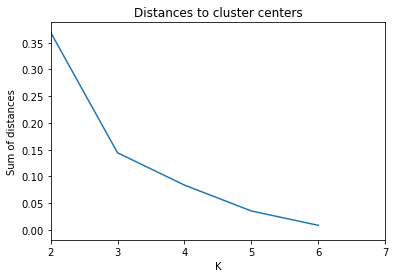

In [349]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure()
plt.plot(squared_distance)
plt.xlabel('K')
plt.ylabel('Sum of distances')
plt.title('Distances to cluster centers')
plt.xlim([2,max_k])
plt.show()

In [350]:
# Based on picture above, the optimum number of clusters is around 5
kmeans = KMeans(n_clusters = 3, random_state = 0).fit(toronto_grouped_clustering)

In [351]:
toronto_grouped_clustering.head()

,Yoga Studio,Airport,American Restaurant,Aquarium,Art Gallery,Asian Restaurant,Bagel Shop,Bakery,Bank,Bar,Baseball Stadium,Basketball Stadium,Beer Bar,Beer Store,Bistro,Bookstore,Breakfast Spot,Brewery,Bubble Tea Shop,Burger Joint,Bus Stop,Café,Chinese Restaurant,Clothing Store,Coffee Shop,College Arts Building,College Gym,Comfort Food Restaurant,Concert Hall,Convenience Store,Dance Studio,Deli / Bodega,Dessert Shop,Diner,Event Space,Fast Food Restaurant,Flower Shop,Food Court,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gastropub,General Travel,Gluten-free Restaurant,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,History Museum,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Italian Restaurant,Japanese Restaurant,Jazz Club,Lake,Liquor Store,Lounge,Mexican Restaurant,Monument / Landmark,Museum,Music Venue,New American Restaurant,Nightclub,Noodle House,Office,Park,Performing Arts Venue,Pharmacy,Pizza Place,Playground,Plaza,Poutine Place,Pub,Rental Car Location,Restaurant,Salad Place,Salon / Barbershop,Sandwich Place,Scenic Lookout,Seafood Restaurant,Shopping Mall,Skating Rink,Smoothie Shop,Soup Place,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Steakhouse,Supermarket,Sushi Restaurant,Tea Room,Thai Restaurant,Theater,Train Station,Vegetarian / Vegan Restaurant,Video Game Store,Wine Bar
0,0.0,0.25,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.25,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.000000,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.25,0.00,0.0,0.00,0.25,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00
1,0.0,0.00,0.04,0.00,0.01,0.01,0.0,0.010000,0.00,0.020000,0.00,0.01,0.020000,0.000000,0.00,0.010000,0.01,0.00,0.00,0.02,0.00,0.080000,0.000000,0.0,0.140000,0.000000,0.000000,0.000000,0.01,0.0,0.00,0.03,0.0,0.0,0.00,0.01,0.0,0.01,0.010000,0.01,0.0,0.03,0.01,0.01,0.01,0.0,0.030000,0.01,0.00,0.08,0.01,0.01,0.00,0.00,0.030000,0.020000,0.000000,0.00,0.0,0.01,0.0,0.00,0.01,0.00,0.01,0.000000,0.010000,0.01,0.00,0.00,0.0,0.01,0.00,0.00,0.000000,0.010000,0.0,0.040000,0.01,0.0,0.010000,0.00,0.02,0.01,0.00,0.00,0.01,0.01,0.01,0.01,0.02,0.02,0.00,0.000000,0.01,0.01,0.010000,0.01,0.00,0.000000,0.01
2,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.000000,0.00,0.00,0.000000,0.000000,0.00,0.000000,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.00,0.5,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.000000,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.000000,0.000000,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.000000,0.000000,0.00,0.50,0.00,0.0,0.00,0.00,0.00,0.000000,0.000000,0.0,0.000000,0.00,0.0,0.000000,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00,0.00,0.000000,0.00
3,0.0,0.00,0.00,0.00,0.00,0.00,0.0,0.058824,0.00,0.058824,0.00,0.00,0.029412,0.029412,0.00,0.058824,0.00,0.00,0.00,0.00,0.00,0.117647,0.029412,0.0,0.058824,0.029412,0.029412,0.029412,0.00,0.0,0.00,0.00,0.0,0.0,0.00,0.00,0.0,0.00,0.029412,0.00,0.0,0.00,0.00,0.00,0.00,0.0,0.029412,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.029412,0.058824,0.029412,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.029412,0.029412,0.00,0.00,0.00,0.0,0.00,0.00,0.00,0.029412,0.029412,0.0,0.058824,0.00,0.0,0.029412,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.029412,0.00,0.00,0.029412,0.00,0.00,0.029412,0.00
4,0.0,0.00,0.01,0.05,0.01,0.00,0.0,0.030000,0.01,0.020000,0.01,0.01,0.010000,0.000000,0.01,0.000000,0.00,0.03,0.01,0.00,0.00,0.040000,0.010000,0.0,0.140000,0.000000,0.000000,0.000000,0.00,0.0,0.01,0.01,0.0,0.0,0.01,0.01,0.0,0.00,0.000000,0.02,0.0,0.00,0.00,0.00,0.00,0.0,0.0000

In [352]:
kmeans.labels_.shape

(7,)

### Clean neighborhoods with missing venues

Some neighborhoods are missing venues and as such are excluded from the analysis. Let's remove them...

In [353]:
# condition to select only the 'actual' neighborhoods
df_toronto[df_toronto.Neighborhood.isin(toronto_grouped.Neighborhood)].shape

(7, 5)

In [354]:
toronto_merged = df_toronto[df_toronto.Neighborhood.isin(toronto_grouped.Neighborhood)]
toronto_merged['Cluster Labels'] = kmeans.labels_
toronto_merged = toronto_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
toronto_merged.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,M3K,North York,"CFB Toronto,Downsview East",43.737473,-79.464763,2,Playground,Airport,Bus Stop,Park,Fast Food Restaurant,Comfort Food Restaurant,Concert Hall,Convenience Store,Dance Studio,Deli / Bodega
40,M4J,East York,East Toronto,43.685347,-79.338106,0,Convenience Store,Park,Wine Bar,Flower Shop,Comfort Food Restaurant,Concert Hall,Dance Studio,Deli / Bodega,Dessert Shop,Diner
46,M4R,Central Toronto,North Toronto West,43.715383,-79.405678,1,Sporting Goods Shop,Coffee Shop,Clothing Store,Yoga Studio,Sandwich Place,Furniture / Home Store,Fast Food Restaurant,Diner,Mexican Restaurant,Dessert Shop
59,M5J,Downtown Toronto,"Harbourfront East,Toronto Islands,Union Station",43.640816,-79.381752,0,Coffee Shop,Aquarium,Hotel,Pizza Place,Café,Scenic Lookout,Brewery,Italian Restaurant,Bakery,Restaurant
60,M5K,Downtown Toronto,"Design Exchange,Toronto Dominion Centre",43.647177,-79.381576,0,Coffee Shop,Hotel,Café,Restaurant,American Restaurant,Deli / Bodega,Gym,Gastropub,Italian Restaurant,Beer Bar


## Cluster map

In [355]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
klclusters = 5
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude']\
                                  , toronto_merged['Longitude']\
                                  , toronto_merged['Neighborhood']\
                                  , toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Examine clusters

### Cluster 1

In [356]:
def getClusterNeighborhoods(cluster_no):
    return toronto_merged.loc[toronto_merged['Cluster Labels'] == cluster_no\
                   , toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]
getClusterNeighborhoods(0)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
40,East York,0,Convenience Store,Park,Wine Bar,Flower Shop,Comfort Food Restaurant,Concert Hall,Dance Studio,Deli / Bodega,Dessert Shop,Diner
59,Downtown Toronto,0,Coffee Shop,Aquarium,Hotel,Pizza Place,Café,Scenic Lookout,Brewery,Italian Restaurant,Bakery,Restaurant
60,Downtown Toronto,0,Coffee Shop,Hotel,Café,Restaurant,American Restaurant,Deli / Bodega,Gym,Gastropub,Italian Restaurant,Beer Bar
66,Downtown Toronto,0,Café,Bakery,Coffee Shop,Restaurant,Japanese Restaurant,Bar,Bookstore,Sushi Restaurant,Sandwich Place,Nightclub
88,Etobicoke,0,Café,Pharmacy,Sandwich Place,Mexican Restaurant,Liquor Store,Fast Food Restaurant,Flower Shop,Restaurant,Fried Chicken Joint,Bakery


### Cluster 2

In [357]:
getClusterNeighborhoods(1)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
46,Central Toronto,1,Sporting Goods Shop,Coffee Shop,Clothing Store,Yoga Studio,Sandwich Place,Furniture / Home Store,Fast Food Restaurant,Diner,Mexican Restaurant,Dessert Shop


### Cluster 3

In [358]:
getClusterNeighborhoods(2)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,North York,2,Playground,Airport,Bus Stop,Park,Fast Food Restaurant,Comfort Food Restaurant,Concert Hall,Convenience Store,Dance Studio,Deli / Bodega


### Cluster 4

In [327]:
getClusterNeighborhoods(3)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,Scarborough,3,Rental Car Location,Pizza Place,Electronics Store,Medical Center,Breakfast Spot,Mexican Restaurant,Women's Store,Doner Restaurant,Diner,Discount Store
13,Scarborough,3,Pizza Place,Pharmacy,Thai Restaurant,Noodle House,Chinese Restaurant,Italian Restaurant,Fried Chicken Joint,Fast Food Restaurant,Gift Shop,Curling Ice
17,North York,3,Dog Run,Mediterranean Restaurant,Golf Course,Pool,Women's Store,Drugstore,Diner,Discount Store,Doner Restaurant,Donut Shop
43,East Toronto,3,Café,Coffee Shop,Italian Restaurant,American Restaurant,Bakery,Sandwich Place,Middle Eastern Restaurant,Bank,Stationery Store,Bar
49,Central Toronto,3,Coffee Shop,Pub,American Restaurant,Convenience Store,Sushi Restaurant,Fried Chicken Joint,Bagel Shop,Sports Bar,Supermarket,Pizza Place
60,Downtown Toronto,3,Coffee Shop,Café,Hotel,American Restaurant,Restaurant,Deli / Bodega,Italian Restaurant,Gym,Gastropub,Sports Bar
61,Downtown Toronto,3,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Bakery,Steakhouse,Deli / Bodega,Gastropub,Gym
65,Central Toronto,3,Coffee Shop,Café,Sandwich Place,Pizza Place,Furniture / Home Store,Park,Pharmacy,Cosmetics Shop,Pub,Burger Joint
70,Downtown Toronto,3,Coffee Shop,Café,Hotel,Restaurant,American Restaurant,Gastropub,Deli / Bodega,Seafood Restaurant,Bar,Bakery
77,West Toronto,3,Bar,Men's Store,Restaurant,Coffee Shop,Café,Asian Restaurant,Bakery,Vietnamese Restaurant,Cocktail Bar,Pizza Place


### Cluster 5

In [328]:
getClusterNeighborhoods(4)

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
68,Downtown Toronto,4,Airport Lounge,Airport Service,Airport Terminal,Boat or Ferry,Boutique,Airport,Airport Food Court,Airport Gate,Harbor / Marina,Plane
82,West Toronto,4,Café,Mexican Restaurant,Fried Chicken Joint,Thai Restaurant,Bakery,Italian Restaurant,Diner,Speakeasy,Furniture / Home Store,Arts & Crafts Store
